In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from tensorflow import keras
from sklearn.svm import SVC,SVR
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [2]:
data =  pd.read_csv("mainSimulationAccessTraces.csv")

In [3]:
display(data.head())
data.info()

,sourceID,sourceAddress,sourceType,sourceLocation,destinationServiceAddress,destinationServiceType,destinationLocation,accessedNodeAddress,accessedNodeType,operation,value,timestamp,normality
0,lightcontrol2,/agent2/lightcontrol2,/lightControler,BedroomParents,/agent2/lightcontrol2,/lightControler,BedroomParents,/agent2/lightcontrol2,/lightControler,registerService,none,1520031600000,normal
1,lightcontrol3,/agent3/lightcontrol3,/lightControler,Dinningroom,/agent3/lightcontrol3,/lightControler,Dinningroom,/agent3/lightcontrol3,/lightControler,registerService,none,1520031603269,normal
2,lightcontrol1,/agent1/lightcontrol1,/lightControler,BedroomChildren,/agent1/lightcontrol1,/lightControler,BedroomChildren,/agent1/lightcontrol1,/lightControler,registerService,none,1520031603279,normal
3,lightcontrol4,/agent4/lightcontrol4,/lightControler,Kitchen,/agent4/lightcontrol4,/lightControler,Kitchen,/agent4/lightcontrol4,/lightControler,registerService,none,1520031603290,normal
4,movement4,/agent4/movement4,/movementSensor,Kitchen,/agent4/movement4,/movementSensor,Kitchen,/agent4/movement4,/movementSensor,registerService,none,1520031603464,normal


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357952 entries, 0 to 357951
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sourceID                   357952 non-null  object
 1   sourceAddress              357952 non-null  object
 2   sourceType                 357952 non-null  object
 3   sourceLocation             357952 non-null  object
 4   destinationServiceAddress  357952 non-null  object
 5   destinationServiceType     357952 non-null  object
 6   destinationLocation        357952 non-null  object
 7   accessedNodeAddress        357952 non-null  object
 8   accessedNodeType           357804 non-null  object
 9   operation                  357952 non-null  object
 10  value                      355902 non-null  object
 11  timestamp                  357952 non-null  int64 
 12  normality                  357952 non-null  object
dtypes: int64(1), object(12)
memory usage: 35.5+ 

In [4]:
# 1. Feature Engineering
# fillna and label encoding 'accessedNodeType' column
print(data['accessedNodeType'].value_counts())
data["accessedNodeType"] = data["accessedNodeType"].astype('category')
data["accessedNodeType_cat"] = data["accessedNodeType"].cat.codes

/sensorService      130155
/derived/boolean     94725
/basic/number        90016
/basic/text          42433
/thermostat            313
/basic/composed        100
/lightControler         23
/movementSensor         22
/batteryService          6
/doorLockService         5
/washingService          3
/smartPhone              3
Name: accessedNodeType, dtype: int64


In [5]:
display(data[data['accessedNodeType_cat'] == -1][['sourceType', 'destinationServiceType', 'accessedNodeAddress','accessedNodeType', 'accessedNodeType_cat', 'normality']])
print(data['accessedNodeType_cat'].value_counts())

,sourceType,destinationServiceType,accessedNodeAddress,accessedNodeType,accessedNodeType_cat,normality
136771,/washingService,/batteryService,/agent5/battery2/charging,NaN,-1,anomalous(malitiousOperation)
136775,/washingService,/batteryService,/agent4/battery3/charging,NaN,-1,anomalous(malitiousOperation)
136776,/washingService,/batteryService,/agent4/battery3/charging,NaN,-1,anomalous(malitiousOperation)
136779,/washingService,/batteryService,/agent5/battery2/charging,NaN,-1,anomalous(malitiousOperation)
136780,/washingService,/batteryService,/agent5/battery2/charging,NaN,-1,anomalous(malitiousOperation)
...,...,...,...,...,...,...
137087,/washingService,/batteryService,/agent5/battery2/charging,NaN,-1,anomalous(malitiousOperation)
137090,/washingService,/batteryService,/agent4/battery3/charging,NaN,-1,anomalous(malitiousOperation)
137092,/washingService,/batteryService,/agent4/battery3/charging,NaN,-1,anomalous(malitiousOperation)
137097,/washingService,/batteryService,/agent4/battery3/charging,NaN,-1,anomalous(malitiousOperation)


 8     130155
 4      94725
 1      90016
 2      42433
 10       313
-1        148
 0        100
 6         23
 7         22
 3          6
 5          5
 9          3
 11         3
Name: accessedNodeType_cat, dtype: int64


In [6]:
data = data.fillna({'accessedNodeType': '/batteryService'})
data["accessedNodeType"] = data["accessedNodeType"].astype('category')
data["accessedNodeType_cat"] = data["accessedNodeType"].cat.codes
print(data['accessedNodeType_cat'].value_counts())

8     130155
4      94725
1      90016
2      42433
10       313
3        154
0        100
6         23
7         22
5          5
9          3
11         3
Name: accessedNodeType_cat, dtype: int64


In [7]:
# fillna with 0 and label encoding 'value' column
data["value"] = data["value"].astype('category')
data["value_cat"] = data["value"].cat.codes
data.head()

,sourceID,sourceAddress,sourceType,sourceLocation,destinationServiceAddress,destinationServiceType,destinationLocation,accessedNodeAddress,accessedNodeType,operation,value,timestamp,normality,accessedNodeType_cat,value_cat
0,lightcontrol2,/agent2/lightcontrol2,/lightControler,BedroomParents,/agent2/lightcontrol2,/lightControler,BedroomParents,/agent2/lightcontrol2,/lightControler,registerService,none,1520031600000,normal,6,10609
1,lightcontrol3,/agent3/lightcontrol3,/lightControler,Dinningroom,/agent3/lightcontrol3,/lightControler,Dinningroom,/agent3/lightcontrol3,/lightControler,registerService,none,1520031603269,normal,6,10609
2,lightcontrol1,/agent1/lightcontrol1,/lightControler,BedroomChildren,/agent1/lightcontrol1,/lightControler,BedroomChildren,/agent1/lightcontrol1,/lightControler,registerService,none,1520031603279,normal,6,10609
3,lightcontrol4,/agent4/lightcontrol4,/lightControler,Kitchen,/agent4/lightcontrol4,/lightControler,Kitchen,/agent4/lightcontrol4,/lightControler,registerService,none,1520031603290,normal,6,10609
4,movement4,/agent4/movement4,/movementSensor,Kitchen,/agent4/movement4,/movementSensor,Kitchen,/agent4/movement4,/movementSensor,registerService,none,1520031603464,normal,7,10609


In [8]:
data[data['value_cat'] == -1][['sourceType', 'destinationServiceType', 'accessedNodeType','value', 'value_cat', 'normality']]

,sourceType,destinationServiceType,accessedNodeType,value,value_cat,normality
35498,/smartPhone,/washingService,/basic/text,NaN,-1,normal
58706,/smartPhone,/washingService,/basic/text,NaN,-1,normal
61348,/batteryService,/washingService,/basic/text,NaN,-1,anomalous(scan)
61377,/batteryService,/washingService,/basic/text,NaN,-1,anomalous(scan)
61418,/batteryService,/washingService,/basic/text,NaN,-1,anomalous(scan)
...,...,...,...,...,...,...
207345,/thermostat,/washingService,/basic/text,NaN,-1,anomalous(DoSattack)
207346,/thermostat,/washingService,/basic/text,NaN,-1,anomalous(DoSattack)
207347,/thermostat,/washingService,/basic/text,NaN,-1,anomalous(DoSattack)
243952,/smartPhone,/washingService,/basic/text,NaN,-1,normal


In [9]:
data = data.fillna({'value': '0'})

In [10]:
data["value"] = data["value"].astype('category')
data["value_cat"] = data["value"].cat.codes
data['value_cat'].value_counts()

2        57047
0        52332
10608    25966
10621    14460
578       9635
         ...  
225          1
23           1
481          1
85           1
183          1
Name: value_cat, Length: 10623, dtype: int64

In [11]:
# label encoding normality
data.loc[data['normality'] != 'normal', 'normality'] = 1
data.loc[data['normality'] == 'normal', 'normality'] = 0
data["normality"] = data["normality"].astype('int8')
data["normality"].value_counts()

0    347935
1     10017
Name: normality, dtype: int64

In [12]:
# encoding all the rest features
data["sourceAddress"] = data["sourceAddress"].astype('category')
data["sourceAddress_cat"] = data["sourceAddress"].cat.codes
data["sourceType"] = data["sourceType"].astype('category')
data["sourceType_cat"] = data["sourceType"].cat.codes
data["sourceLocation"] = data["sourceLocation"].astype('category')
data["sourceLocation_cat"] = data["sourceLocation"].cat.codes
data["destinationServiceAddress"] = data["destinationServiceAddress"].astype('category')
data["destinationServiceAddress_cat"] = data["destinationServiceAddress"].cat.codes
data["destinationServiceType"] = data["destinationServiceType"].astype('category')
data["destinationServiceType_cat"] = data["destinationServiceType"].cat.codes
data["destinationLocation"] = data["destinationLocation"].astype('category')
data["destinationLocation_cat"] = data["destinationLocation"].cat.codes
data["accessedNodeAddress"] = data["accessedNodeAddress"].astype('category')
data["accessedNodeAddress_cat"] = data["accessedNodeAddress"].cat.codes
data["operation"] = data["operation"].astype('category')
data["operation_cat"] = data["operation"].cat.codes

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357952 entries, 0 to 357951
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   sourceID                       357952 non-null  object  
 1   sourceAddress                  357952 non-null  category
 2   sourceType                     357952 non-null  category
 3   sourceLocation                 357952 non-null  category
 4   destinationServiceAddress      357952 non-null  category
 5   destinationServiceType         357952 non-null  category
 6   destinationLocation            357952 non-null  category
 7   accessedNodeAddress            357952 non-null  category
 8   accessedNodeType               357952 non-null  category
 9   operation                      357952 non-null  category
 10  value                          357952 non-null  category
 11  timestamp                      357952 non-null  int64   
 12  normality       

In [54]:
# 2. Train test split
x = data[['sourceType_cat', 'sourceAddress_cat', 'sourceLocation_cat', 'destinationServiceType_cat', 'destinationServiceAddress_cat', 'destinationLocation_cat', 'accessedNodeType_cat', 'accessedNodeAddress_cat', 'operation_cat', 'value_cat']]
y = data[['normality']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
pd.Series(y_train).value_counts()

0    243577
1      6989
dtype: int64

In [57]:
# 3. Model training XGBoost (without oversampling)
model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder =False, learning_rate= 1.5358256467186069, n_estimators = 35, max_depth = 14, verbosity = 0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Confusion matrix of XGBoost (without oversampling):


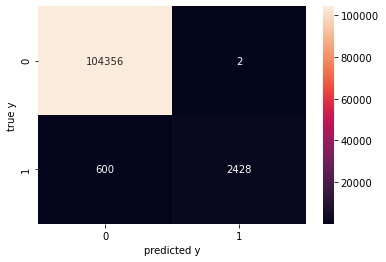


Accuracy: 0.9943940551
Precision: 0.994421306262763
Recall: 0.9943940550909802
F1 score: 0.9940949583342806


In [58]:
print("Confusion matrix of XGBoost (without oversampling):")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel("predicted y")
plt.ylabel("true y")
plt.show()
score = accuracy_score(y_test, y_pred)
precision, recall, f1score, ___ = precision_recall_fscore_support(y_test, y_pred, average='weighted') 
print("\nAccuracy: %.10f" %(score))
print('Precision: %s' %(precision))
print('Recall: %s' %(recall))
print('F1 score: %s' %(f1score))

In [63]:
# Hyperparameter optimization for XGBoost using BO-TPE (Bayesian Optimization with Tree-structured Parzen Estimator)
# L. Yang and A. Shami, “On hyperparameter optimization of machine learning algorithms: Theory and practice,” Neurocomputing, vol. 415, pp. 295–316, 2020, doi: https://doi.org/10.1016/j.neucom.2020.07.061.
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),
        'objective':str(params['objective'])
    }
    clf = xgb.XGBClassifier(**params, use_label_encoder=False, verbosity=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'objective':hp.choice('objective', ['binary:logistic','binary:logitraw', 'binary:hinge'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [01:23<00:00,  4.19s/trial, best loss: -0.9934162740021977]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.12960031897473898, 'max_depth': 20.0, 'n_estimators': 60.0, 'objective': 2}


In [65]:
# 4. Model training XGBoost (SMOTE oversampling)
smote = SMOTE(n_jobs=-1, sampling_strategy={1:15000})
X_train, y_train = smote.fit_resample(X_train, y_train)
pd.Series(y_train).value_counts()

0    243577
1     15000
dtype: int64

Confusion matrix of XGBoost (with oversampling):


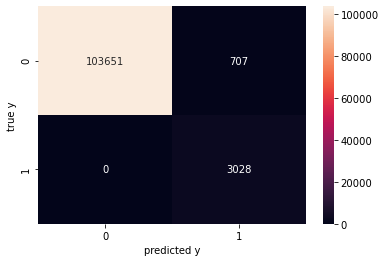


Accuracy: 0.9934162740
Precision: 0.9946625107573372
Recall: 0.9934162740021977
F1 score: 0.9937492147185665


In [64]:
model = xgb.XGBClassifier(objective='binary:hinge', use_label_encoder =False, learning_rate= 0.12960031897473898, n_estimators = 60, max_depth = 20, verbosity = 0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Confusion matrix of XGBoost (with oversampling):")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel("predicted y")
plt.ylabel("true y")
plt.show()
score = accuracy_score(y_test, y_pred)
precision, recall, f1score, ___ = precision_recall_fscore_support(y_test, y_pred, average='weighted') 
print("\nAccuracy: %.10f" %(score))
print('Precision: %s' %(precision))
print('Recall: %s' %(recall))
print('F1 score: %s' %(f1score))

Confusion matrix of Random Forest (without oversampling):


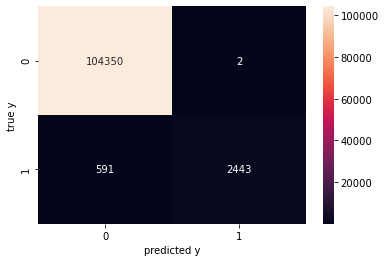


Accuracy: 0.9944778649
Precision: 0.994504267715256
Recall: 0.9944778648985901
F1 score: 0.9941888166544491


In [28]:
# 5. Model training Random Forest (without oversampling)
rf = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 1, max_depth = 32, min_samples_split = 3, max_features = 7, criterion = 'gini')
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print("Confusion matrix of Random Forest (without oversampling):")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel("predicted y")
plt.ylabel("true y")
plt.show()
score = accuracy_score(y_test, y_pred)
precision, recall, f1score, ___ = precision_recall_fscore_support(y_test, y_pred, average='weighted') 
print("\nAccuracy: %.10f" %(score))
print('Precision: %s' %(precision))
print('Recall: %s' %(recall))
print('F1 score: %s' %(f1score))

In [23]:
# Hyperparameter optimization for Random Forest using BO-TPE (Bayesian Optimization with Tree-structured Parzen Estimator)
# L. Yang and A. Shami, “On hyperparameter optimization of machine learning algorithms: Theory and practice,” Neurocomputing, vol. 415, pp. 295–316, 2020, doi: https://doi.org/10.1016/j.neucom.2020.07.061.
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
    #print("ROC-AUC {:.3f} params {}".format(score, params))

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 10, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [12:42<00:00, 38.14s/trial, best loss: -0.9944086587964848]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 32.0, 'max_features': 7.0, 'min_samples_leaf': 1.0, 'min_samples_split': 3.0, 'n_estimators': 40.0}


Confusion matrix of Random Forest (with oversampling):


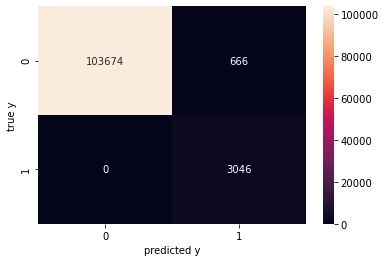


Accuracy: 0.9937980742
Precision: 0.9949108119950137
Recall: 0.9937980742368652
F1 score: 0.9940937453395163


In [25]:
# 5. Model training Random Forest (with oversampling)
smote = SMOTE(n_jobs=-1, sampling_strategy={1:15000})
X_train, y_train = smote.fit_resample(X_train, y_train)
pd.Series(y_train).value_counts()
rf = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 1, max_depth = 32, min_samples_split = 3, max_features = 7, criterion = 'gini')
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print("Confusion matrix of Random Forest (with oversampling):")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel("predicted y")
plt.ylabel("true y")
plt.show()
score = accuracy_score(y_test, y_pred)
precision, recall, f1score, ___ = precision_recall_fscore_support(y_test, y_pred, average='weighted') 
print("\nAccuracy: %.10f" %(score))
print('Precision: %s' %(precision))
print('Recall: %s' %(recall))
print('F1 score: %s' %(f1score))